In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 294 ms (started: 2022-09-12 23:11:16 -07:00)


The [COIL-100 Columbia Object Image Library](http://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php): : 7200 color images at a 128 x 128 resolution (= 49152 features, the value of the 16384 pixels in the red, green and blue channels separately) -- 100 objects with 72 poses each. See also the `coil20.ipynb` for the related (smaller, black and white) COIL-20 dataset.

## Read the zip file

In [3]:
import zipfile
from io import BytesIO

import requests

url = "http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip"
req = requests.get(url, timeout=10)

zip_file = zipfile.ZipFile(BytesIO(req.content))

time: 7.07 s (started: 2022-09-12 23:16:00 -07:00)


In [21]:
zip_file.infolist()[:100][-1]

<ZipInfo filename='coil-100/obj10__205.png' compress_type=deflate filemode='-rw-rw-rw-' file_size=19299 compress_size=19256>

time: 3.4 ms (started: 2022-09-12 23:26:21 -07:00)


In [5]:
zip_infos = [
    zip_info
    for zip_info in zip_file.infolist()
    if not zip_info.is_dir() and zip_info.filename.endswith(".png")
]

time: 6.29 ms (started: 2022-09-12 23:16:27 -07:00)


Before reading the files, create a numpy `ndarray` that can store the image data:

In [23]:
n_objects = 100
n_poses = 72
nx = 128
ny = 128
nchannels = 3
n_features = nx * ny * nchannels
img_data = np.empty([n_objects * n_poses, n_features], dtype=int)
img_data.shape

(7200, 49152)

time: 6.88 ms (started: 2022-09-12 23:29:22 -07:00)


Also some notes on the filename that we will need to know:

* filename is of the form `coil-100/obj10__205.png`
* The directory name is uninformative so we can ignore that.
* `obj10` => object id is 10 and is 1-indexed
* `__205` => view angle is 205 degrees. Divide by 5 to get the pose id, in this case 41.

The following code fills the array. This is the most time-consuming step (expect it to take a minute or so):

In [32]:
import PIL.Image

for zip_info in zip_infos:
    _, png_filename = zip_info.filename.split("/")
    object_id, view_angle = png_filename.split("__")
    object_id = int(object_id[3:])
    pose_id = int(int(view_angle[:-4]) / 5)
    # then convert to 1D row index of output data
    idx = (object_id - 1) * n_poses + pose_id
    with zip_file.open(zip_info.filename) as png_file:
        img = PIL.Image.open(png_file)
        # img.getdata() returns a list of 3-tuples (the red, green, blue value per pixel)
        # ravel flattens to a 1D array
        img_data[idx, :] = np.array(img.getdata()).ravel()

time: 1min 2s (started: 2022-09-12 23:34:25 -07:00)


In [35]:
img_data[0], img_data[-1]

(array([53, 51, 32, ..., 25, 25, 25]), array([53, 51, 32, ..., 25, 25, 25]))

time: 4.65 ms (started: 2022-09-12 23:39:51 -07:00)


Don't forget to close the zip file:

In [50]:
zip_file.close()

time: 1.43 ms (started: 2022-09-12 23:43:07 -07:00)


## View object image

In [42]:
import matplotlib.pyplot as plt


def show_coil100_object(coil100, obj, pose):
    if not 0 <= obj < 100:
        raise ValueError("obj should be a value in [0, 100]")
    n_poses = 72
    if not 0 <= pose < n_poses:
        raise ValueError("pose should be a value in [0, 71]")
    idx = obj * n_poses + pose
    nx = 128
    ny = 128
    n_channels = 3
    if coil100.shape[1] != nx * ny * n_channels:
        raise ValueError(
            f"coil100 image should have {nx} x {ny} x {n_channels} features"
        )
    plt.imshow(
        coil100[idx].reshape((ny, nx, n_channels)),
        interpolation="nearest",
        vmin=0,
        vmax=255,
    )

time: 6.27 ms (started: 2022-09-12 23:42:20 -07:00)


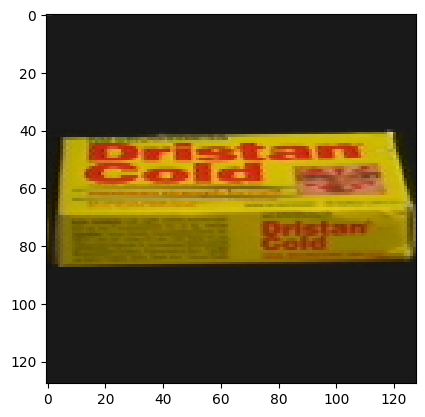

time: 159 ms (started: 2022-09-12 23:43:02 -07:00)


In [49]:
show_coil100_object(img_data, 0, 0)

## Pipeline

In [54]:
from drnb.util import categorize

target = pd.DataFrame(
    dict(
        view_angle=list(range(0, 360, 5)) * n_objects,
        pose_id=list(range(n_poses)) * n_objects,
        object_id=np.repeat(range(n_objects), n_poses),
    )
)
categorize(target, "object_id")
target

,view_angle,pose_id,object_id
0,0,0,0
1,5,1,0
2,10,2,0
3,15,3,0
4,20,4,0
...,...,...,...
7195,335,67,99
7196,340,68,99
7197,345,69,99
7198,350,70,99


time: 15.8 ms (started: 2022-09-12 23:46:41 -07:00)


In [55]:
from drnb.dataset import create_data_pipeline

data_pipe = create_data_pipeline(
    data_export=["csv", "npy"],
    target_export=["csv", "pkl"],
    neighbors=dict(
        n_neighbors=[15, 50, 150],
        method="exact",
        metric=["euclidean"],
        file_types=["csv", "npy"],
    ),
    triplets=dict(
        n_triplets_per_point=5,
        seed=1337,
        file_types=["csv", "npy"],
    ),
    verbose=True,
)

[23:47:05] INFO     Requesting one extra neighbor to account for self-neighbor                       ]8;id=538227;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=772979;file:///home/james/dev/drnb/src/drnb/dataset.py#318\318]8;;\

time: 11.6 ms (started: 2022-09-12 23:47:04 -07:00)


In [56]:
data_result = data_pipe.run("coil100", data=img_data, target=target, verbose=True)

[23:47:21] INFO     initial data shape: (7200, 49152)                                                 ]8;id=89543;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=294295;file:///home/james/dev/drnb/src/drnb/dataset.py#45\45]8;;\

           INFO     Removing rows with NAs                                                            ]8;id=596767;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=200342;file:///home/james/dev/drnb/src/drnb/dataset.py#85\85]8;;\

[23:47:22] INFO     data shape after filtering NAs: (7200, 49152)                                     ]8;id=851551;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=984620;file:///home/james/dev/drnb/src/drnb/dataset.py#94\94]8;;\

           INFO     Keeping all columns                                                            ]8;id=869686;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=28466;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     data shape after filtering columns: (7200, 49152)                                 ]8;id=748107;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=557041;file:///home/james/dev/drnb/src/drnb/dataset.py#99\99]8;;\

           INFO     No scaling                                                                     ]8;id=880336;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=520517;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                     ]8;id=302163;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=817924;file:///home/james/dev/drnb/src/drnb/dataset.py#104\104]8;;\

           INFO     Writing data for coil100                                                         ]8;id=302999;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=890455;file:///home/james/dev/drnb/src/drnb/dataset.py#162\162]8;;\

[23:49:22] INFO     Processing target with initial shape (7200, 3)                                   ]8;id=269245;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=769292;file:///home/james/dev/drnb/src/drnb/dataset.py#133\133]8;;\

           INFO     Keeping all columns                                                            ]8;id=557816;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=856636;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Writing target for coil100                                                       ]8;id=566525;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=495538;file:///home/james/dev/drnb/src/drnb/dataset.py#162\162]8;;\

           INFO     Calculating nearest neighbors                                                    ]8;id=179460;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=760527;file:///home/james/dev/drnb/src/drnb/dataset.py#173\173]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=508452;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=452806;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=660063;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=788036;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=143991;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=988212;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=801710;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=625119;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=320489;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=440342;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[23:49:31] INFO     Calculating triplets                                                             ]8;id=26116;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=151695;file:///home/james/dev/drnb/src/drnb/dataset.py#209\209]8;;\

[23:49:33] INFO     Writing csv format to triplets/coil100.5.1337.idx.csv                           ]8;id=504810;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=269251;file:///home/james/dev/drnb/src/drnb/io/__init__.py#207\207]8;;\

           INFO     Writing csv format to triplets/coil100.5.1337.l2.csv                            ]8;id=498704;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=672858;file:///home/james/dev/drnb/src/drnb/io/__init__.py#207\207]8;;\

           INFO     Writing numpy format to triplets/coil100.5.1337.idx.npy                         ]8;id=177978;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=461669;file:///home/james/dev/drnb/src/drnb/io/__init__.py#230\230]8;;\

           INFO     Writing numpy format to triplets/coil100.5.1337.l2.npy                          ]8;id=206133;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=1961;file:///home/james/dev/drnb/src/drnb/io/__init__.py#230\230]8;;\

           INFO     Writing pipeline result for coil100                                               ]8;id=727853;file:///home/james/dev/drnb/src/drnb/dataset.py\dataset.py]8;;\:]8;id=377217;file:///home/james/dev/drnb/src/drnb/dataset.py#79\79]8;;\

time: 2min 11s (started: 2022-09-12 23:47:21 -07:00)
